# Building an Anomaly Detection Model Using LSTM Autoencoder

In [67]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10

import warnings
warnings.filterwarnings("ignore")

## Data Loading and Preprocessing

In [2]:
data = yf.download('^GSPC', start='1980-01-01', end='2023-01-01',multi_level_index = False,progress=False)
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
1980-01-02,105.760002,108.430000,105.290001,0.0,40610000
1980-01-03,105.220001,106.080002,103.260002,0.0,50480000
1980-01-04,106.519997,107.080002,105.089996,0.0,39130000
1980-01-07,106.809998,107.800003,105.800003,0.0,44500000
1980-01-08,108.949997,109.290001,106.290001,0.0,53390000


In [3]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
df = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
1980-01-02,0.001605,0.001875,0.002360,0.0,0.002239
1980-01-03,0.001490,0.001377,0.001927,0.0,0.003102
1980-01-04,0.001767,0.001589,0.002318,0.0,0.002110
1980-01-07,0.001828,0.001742,0.002469,0.0,0.002579
1980-01-08,0.002284,0.002058,0.002574,0.0,0.003356


## Visualizing Stock Prices and Volumes

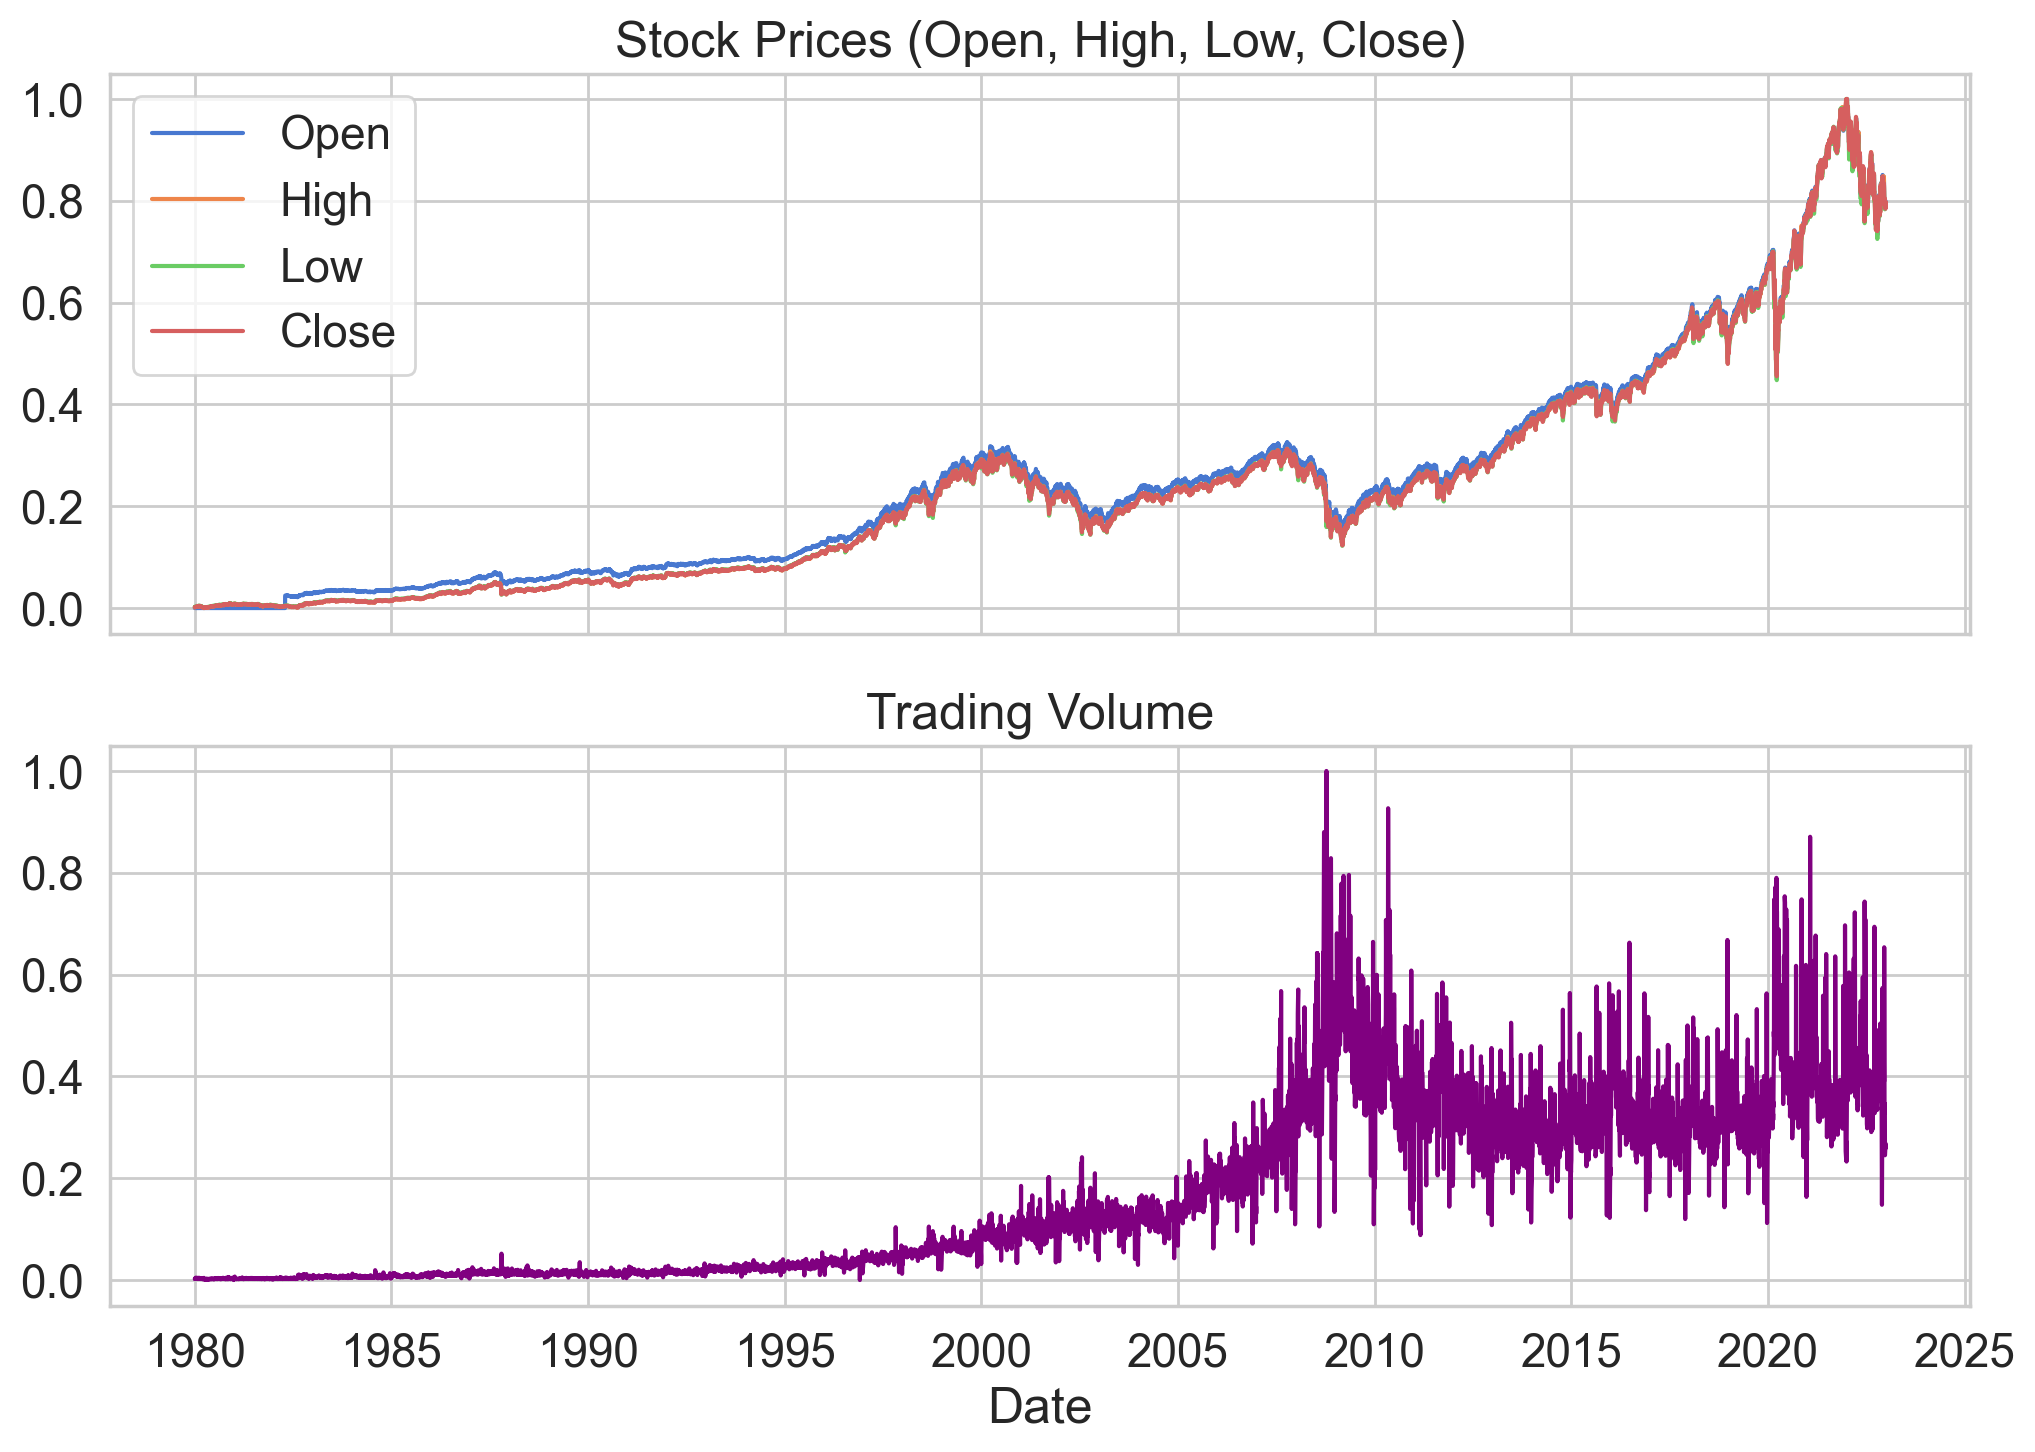

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Prices
ax[0].plot(df.index, df[['Open', 'High', 'Low', 'Close']])
ax[0].set_title("Stock Prices (Open, High, Low, Close)")
ax[0].legend(['Open', 'High', 'Low', 'Close'])

# Plot Volume
ax[1].plot(df.index, df['Volume'], color='purple')
ax[1].set_title("Trading Volume")

plt.xlabel("Date")
plt.show()

## Building the Training and Testing Dataset

In [5]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(10300, 5) (543, 5)


In [6]:
def create_multivariate_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [7]:
TIME_STEPS = 30

X_train, y_train = create_multivariate_dataset(train[['Open', 'High', 'Low', 'Close', 'Volume']], train['Close'], TIME_STEPS)
X_test, y_test = create_multivariate_dataset(test[['Open', 'High', 'Low', 'Close', 'Volume']], test['Close'], TIME_STEPS)

print("Shape of X_train:", X_train.shape)  
print("Shape of y_train:", y_train.shape)  
print("Shape of X_test:", X_test.shape)    
print("Shape of y_test:", y_test.shape)    

Shape of X_train: (10270, 30, 5)
Shape of y_train: (10270,)
Shape of X_test: (513, 30, 5)
Shape of y_test: (513,)


## Building and Training the LSTM Autoencoder Model

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

model = keras.Sequential()
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', input_shape=(TIME_STEPS, X_train.shape[2]), return_sequences=True, name='encoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
model.add(keras.layers.RepeatVector(TIME_STEPS, name='encoder_decoder_bridge'))
model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))  # Predicting just one value for each time step (Close price)

model.compile(loss="mse", optimizer='adam')
print(model.summary())


C:\Users\ASUS\anaconda3\envs\dl\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_1 (LSTM)                     │ (None, 30, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2 (LSTM)                     │ (None, 30, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3 (LSTM)                     │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_decoder_bridge               │ (None, 30, 16)              │               0 │
│ (RepeatVector)                       │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (LSTM)                     │ (None, 30, 16)              │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_2 (LSTM)                     │ (None, 30, 32)              │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_3 (LSTM)                     │ (None, 30, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,753 (260.75 KB)

 Trainable params: 66,753 (260.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
history=model.fit(
    x=X_train, 
    y=y_train, 
    validation_split=0.1, 
    epochs=10, 
    batch_size=32, 
    shuffle=False
)

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 6.3467e-04 - val_loss: 0.0186
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0049 - val_loss: 0.0237
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0011 - val_loss: 0.0202
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0018 - val_loss: 0.0204
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 6.2382e-04 - val_loss: 0.0152
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 7.9049e-04 - val_loss: 0.0176
Epoch 7/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 7.0080e-04 - val_loss: 0.0168
Epoch 8/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 4.4765e-04 - val_loss: 0.0186
Epoch 9/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 6.6890e-04 - val_loss: 0.0225
Epoch 10/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0011 - val_loss: 0.0180


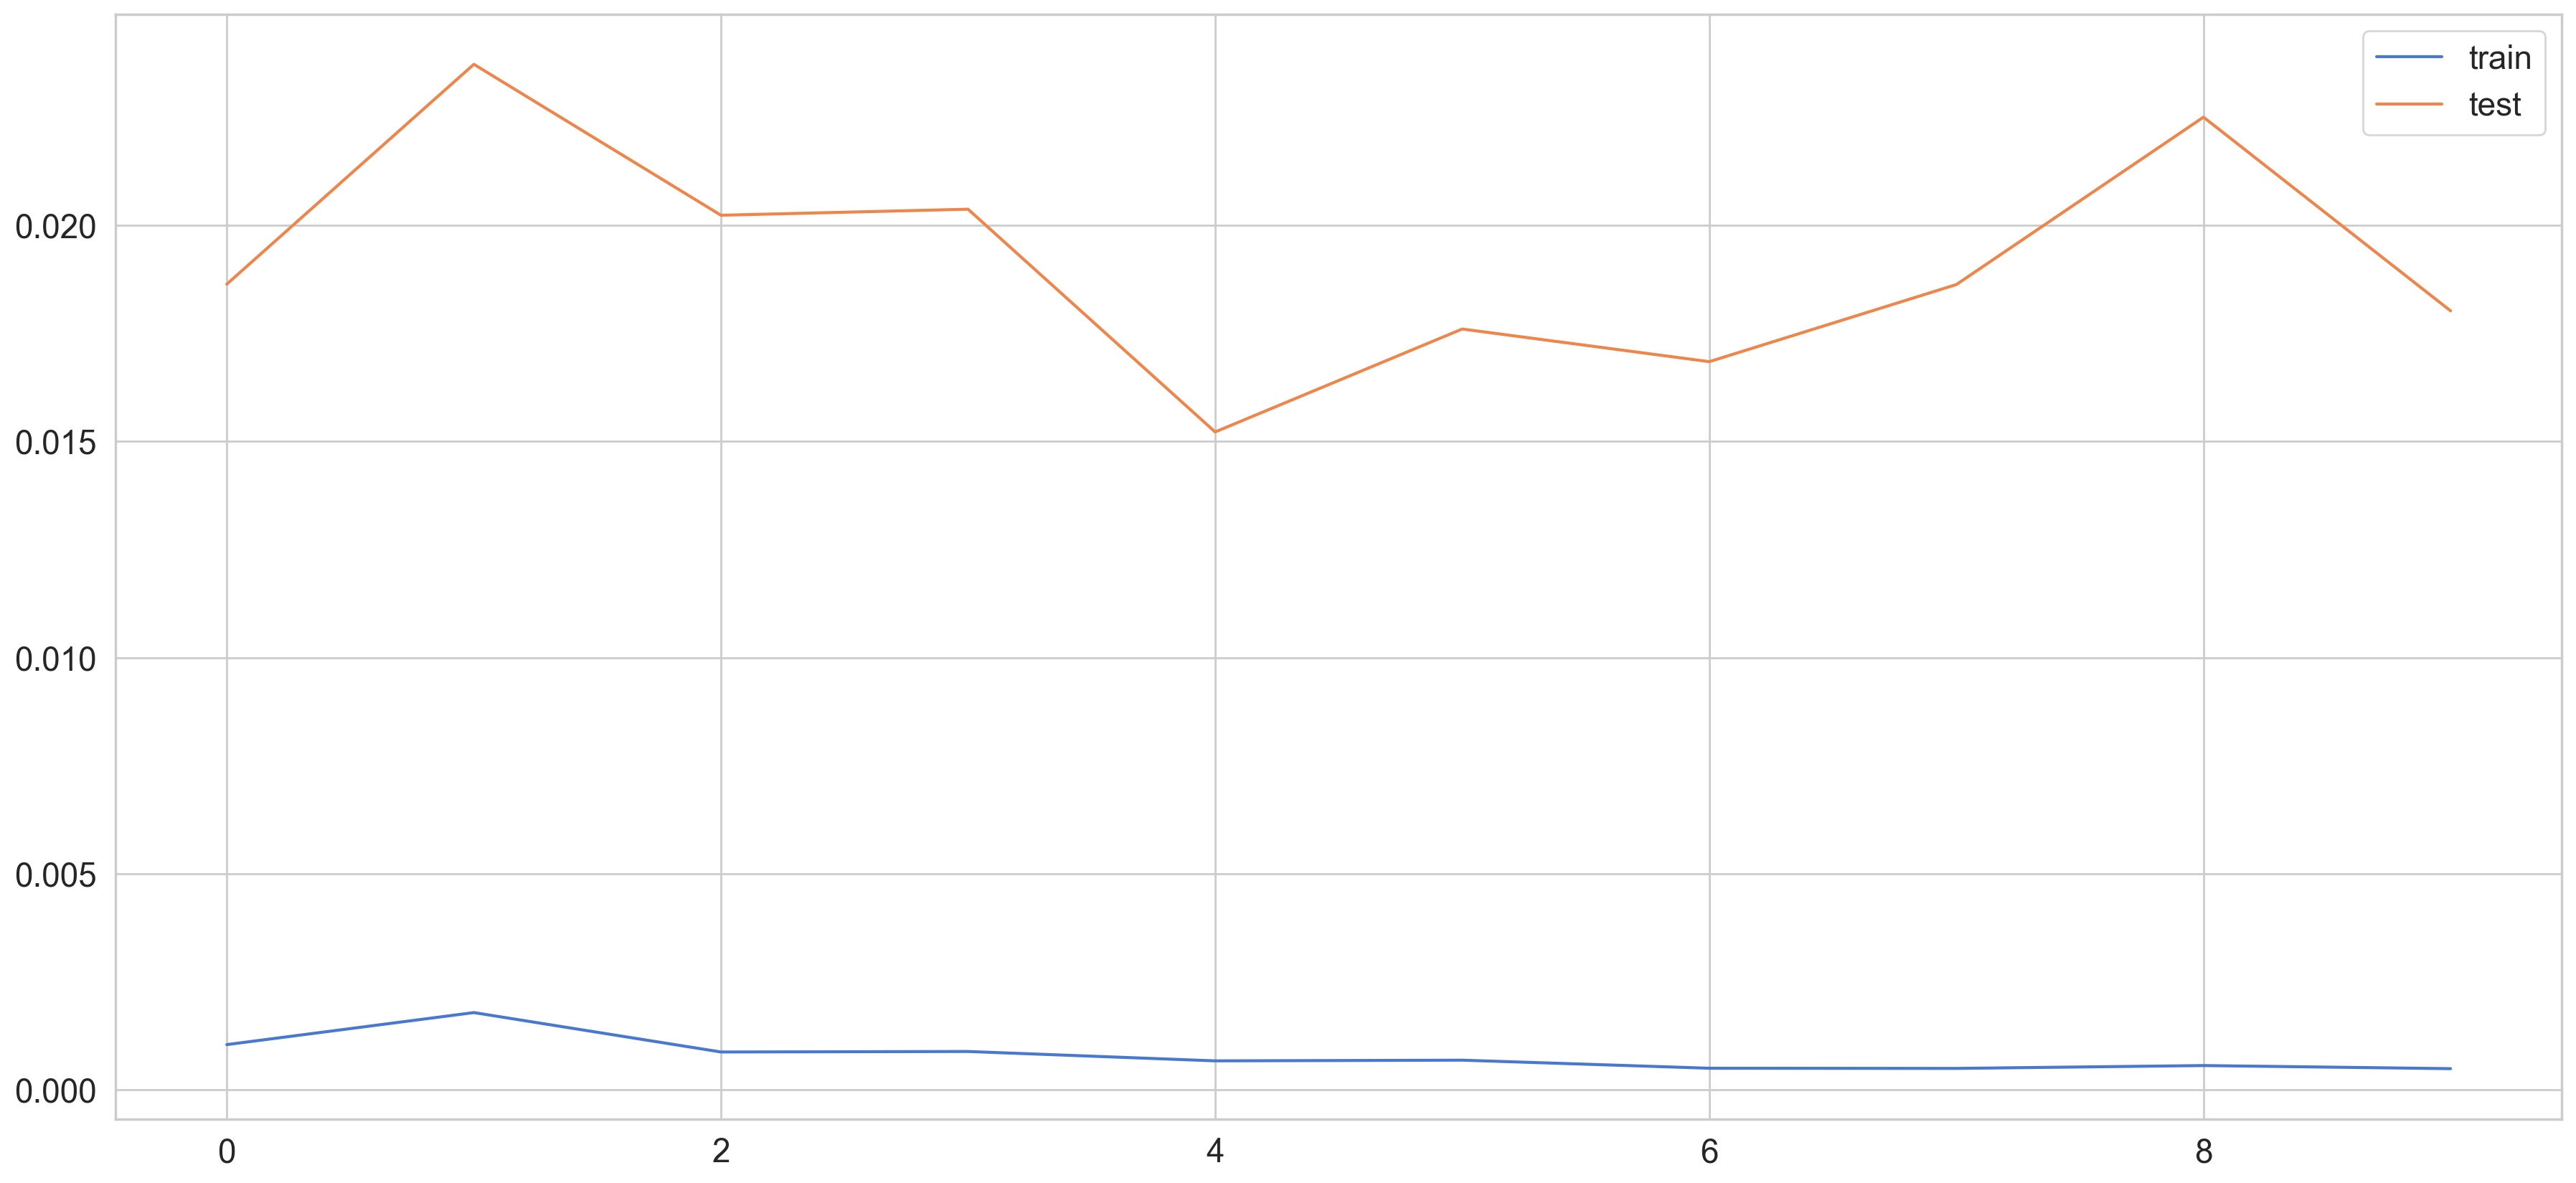

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [11]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


C:\Users\ASUS\AppData\Local\Temp\ipykernel_45024\1731640021.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


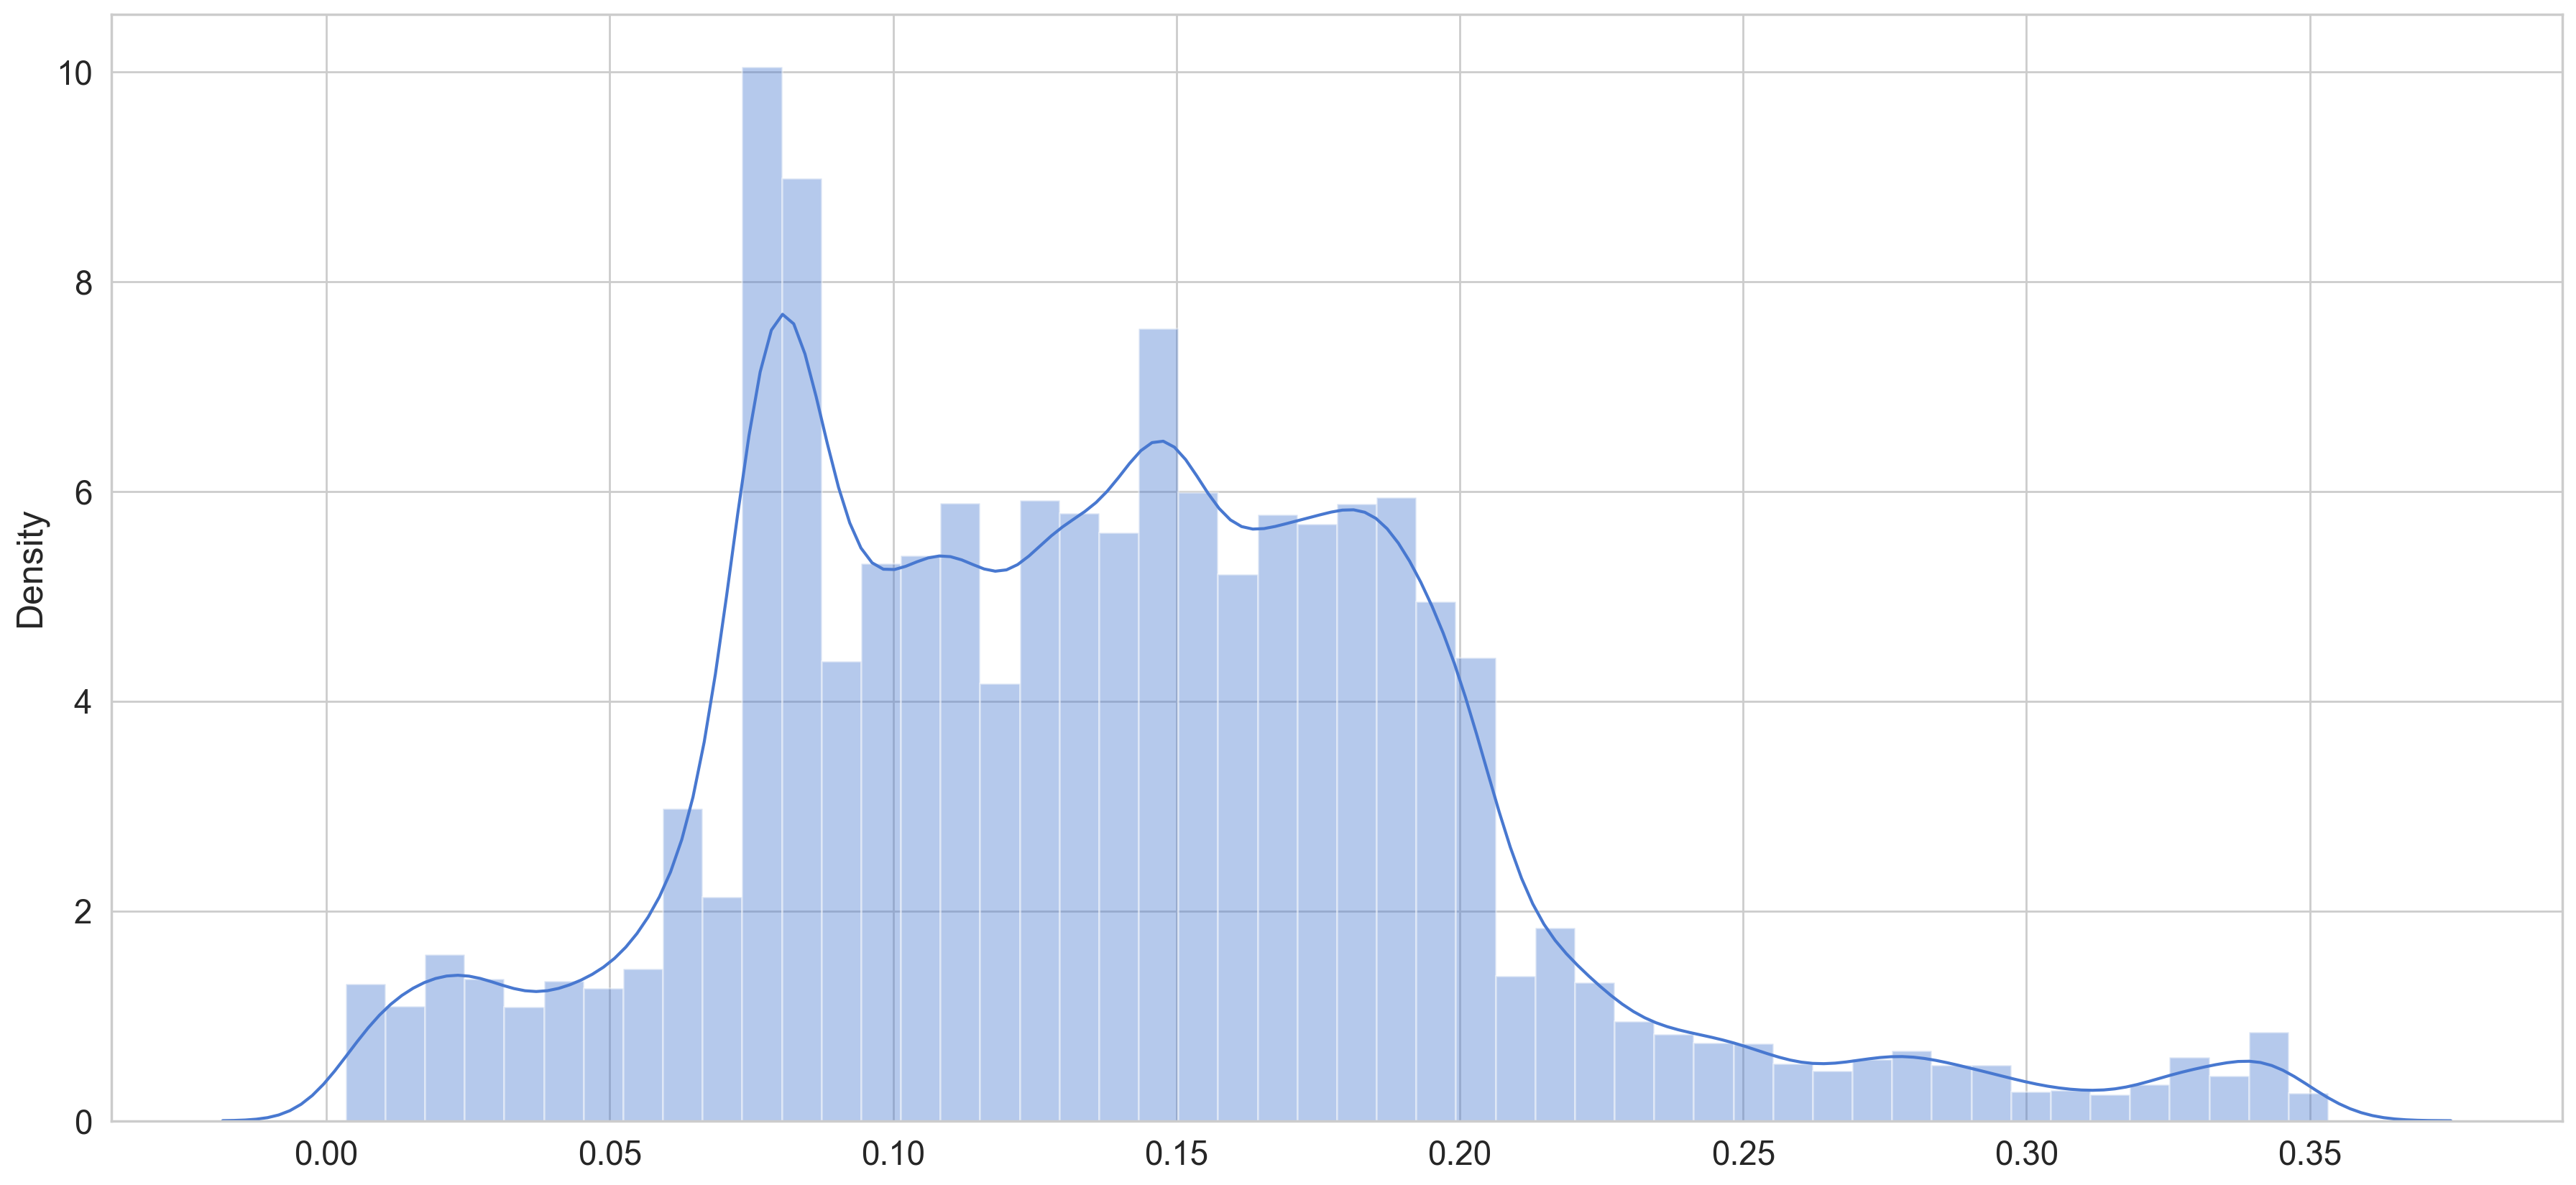

In [12]:
sns.distplot(train_mae_loss, bins=50, kde=True);

## Model Testing and Evaluation

In [37]:
X_test_pred = model.predict(X_test)
X_test_close = X_test[:, :, 3:4]
test_mae_loss = np.mean(np.abs(X_test_pred - X_test_close), axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [52]:
test.Close

Date
2020-11-04    0.712000
2020-11-05    0.726263
2020-11-06    0.726048
2020-11-09    0.734787
2020-11-10    0.733729
                ...   
2022-12-23    0.797431
2022-12-27    0.794117
2022-12-28    0.784320
2022-12-29    0.798380
2022-12-30    0.796298
Name: Close, Length: 543, dtype: float64

In [53]:
 test[TIME_STEPS:].Close

Date
2020-12-17    0.771392
2020-12-18    0.768610
2020-12-21    0.765526
2020-12-22    0.763895
2020-12-23    0.764481
                ...   
2022-12-23    0.797431
2022-12-27    0.794117
2022-12-28    0.784320
2022-12-29    0.798380
2022-12-30    0.796298
Name: Close, Length: 513, dtype: float64

In [58]:
THRESHOLD = 0.45

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df[['Open', 'High', 'Low', 'Close', 'Volume']] = test[TIME_STEPS:][['Open', 'High', 'Low', 'Close', 'Volume']]

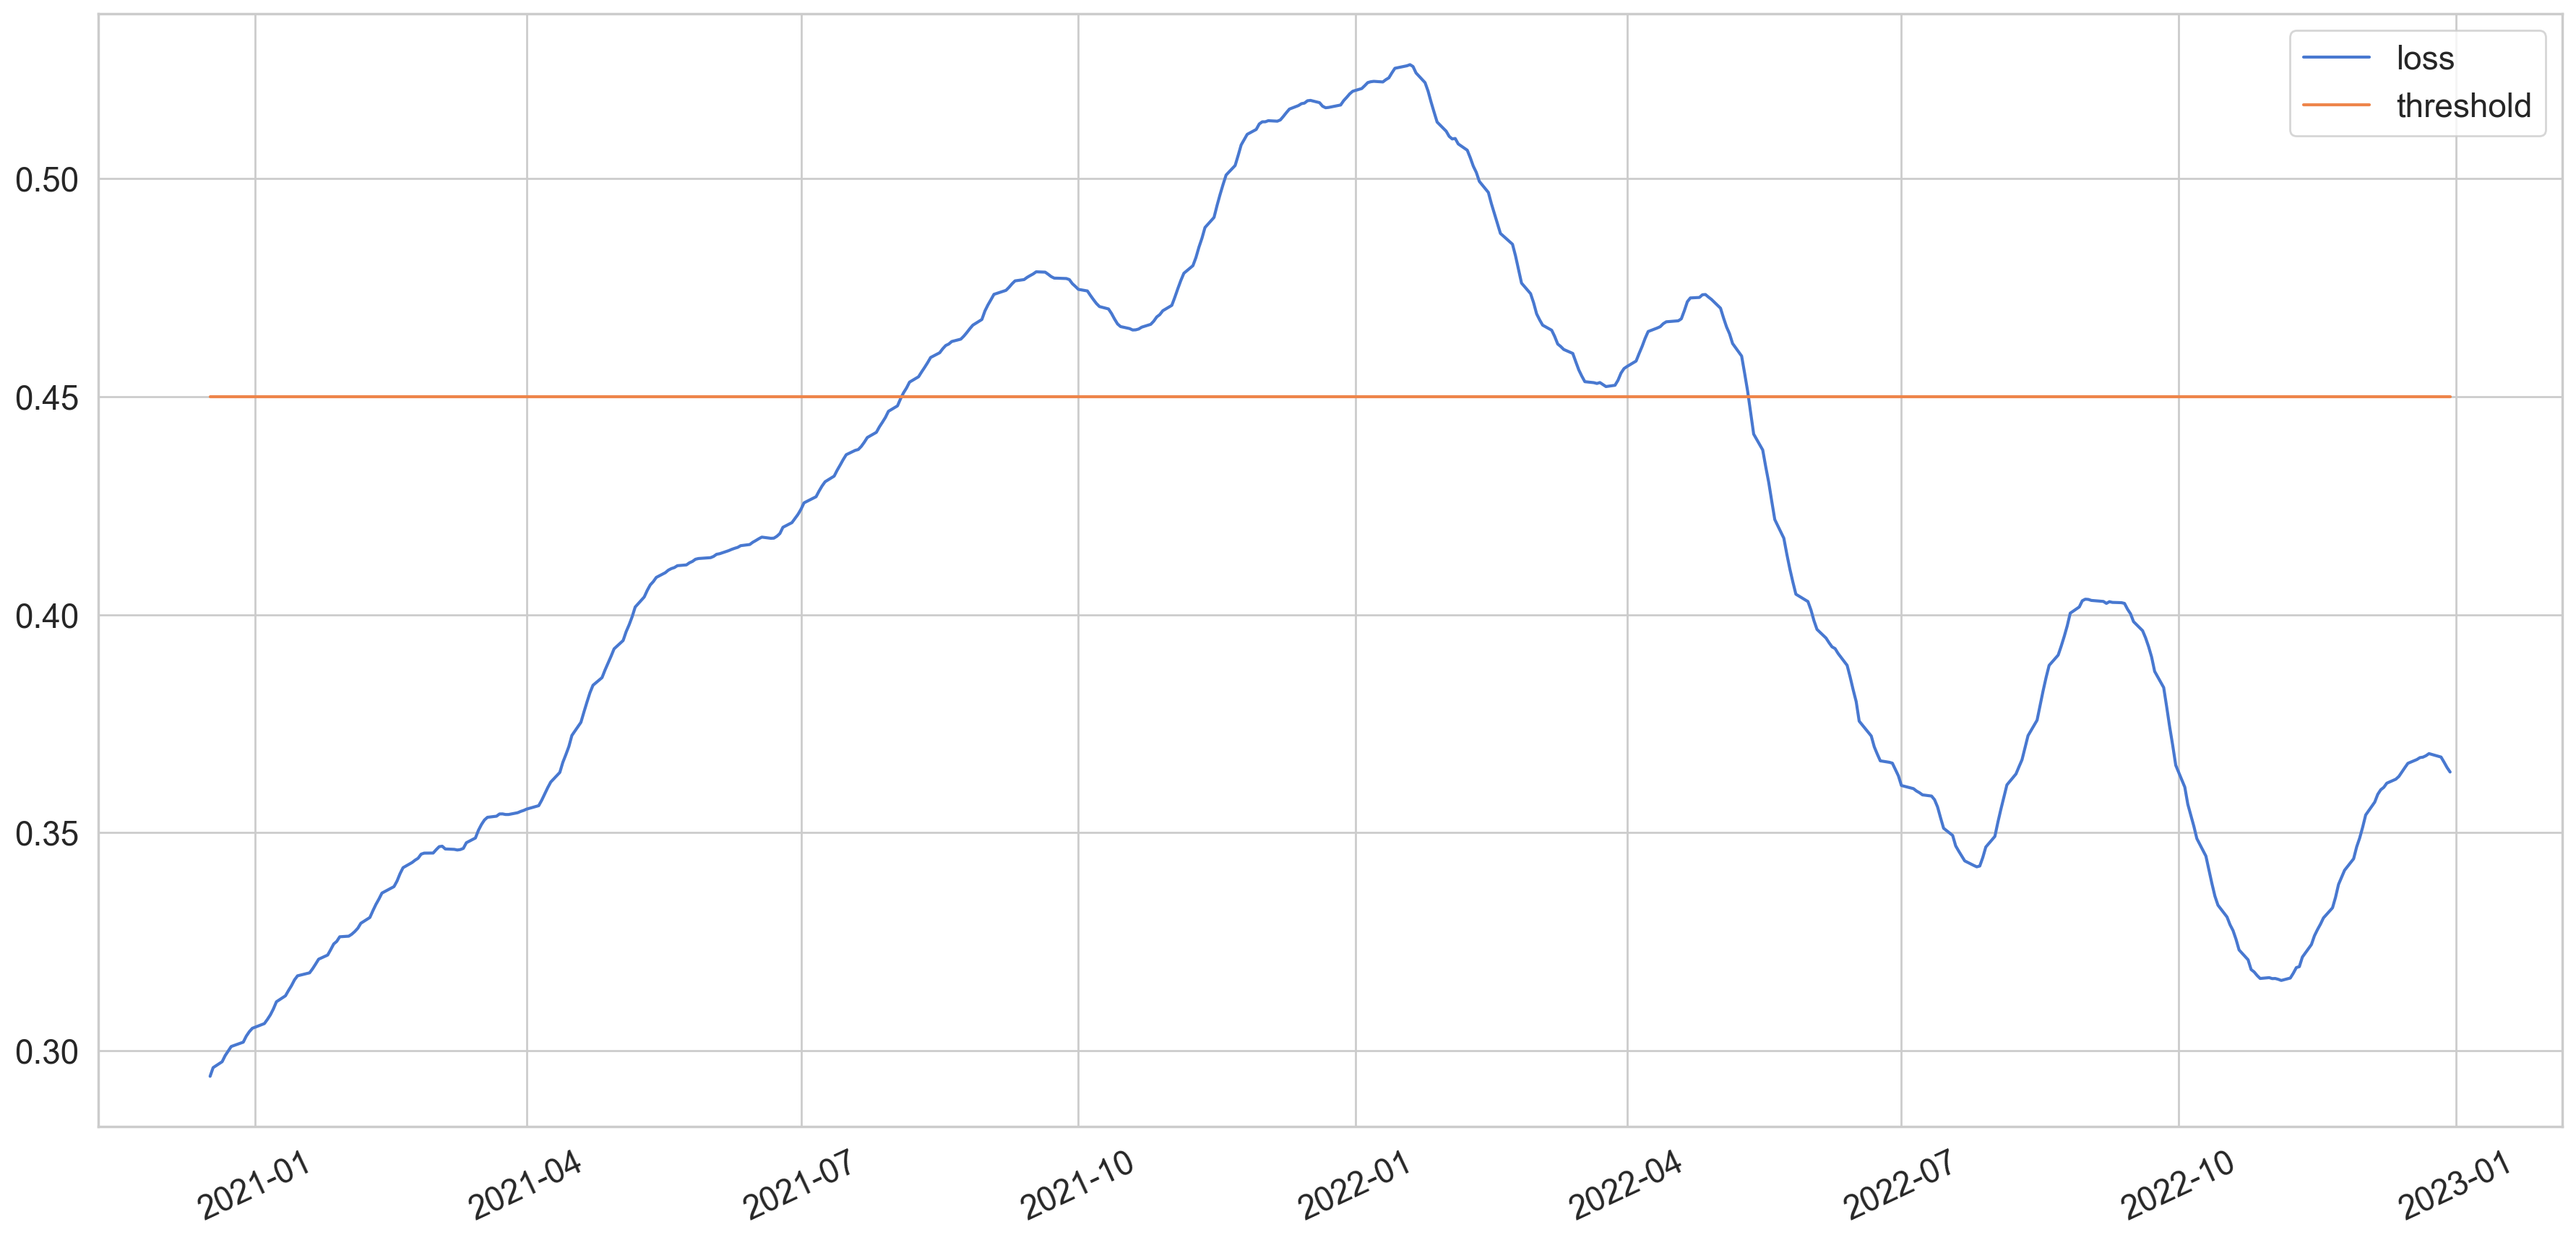

In [41]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

## Visualizing the Detected Anomalies

In [59]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,Open,High,Low,Close,Volume
Date,,,,,,,,
2021-08-04,0.450895,0.45,True,0.919126,0.914718,0.918945,0.916162,0.371094
2021-08-05,0.452000,0.45,True,0.917650,0.917598,0.920786,0.921789,0.328148
2021-08-06,0.453352,0.45,True,0.921857,0.919941,0.925099,0.923369,0.300394
2021-08-09,0.454585,0.45,True,0.923668,0.919638,0.924175,0.922481,0.300168
2021-08-10,0.455686,0.45,True,0.923255,0.920872,0.925304,0.923418,0.338392


In [61]:
anomalies.drop(['loss','threshold','anomaly'],axis=1,inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_45024\1958493649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies.drop(['loss','threshold','anomaly'],axis=1,inplace=True)


In [63]:
scaled_anomalies=scaler.inverse_transform(anomalies)
scaled_anomalies.shape

(195, 5)

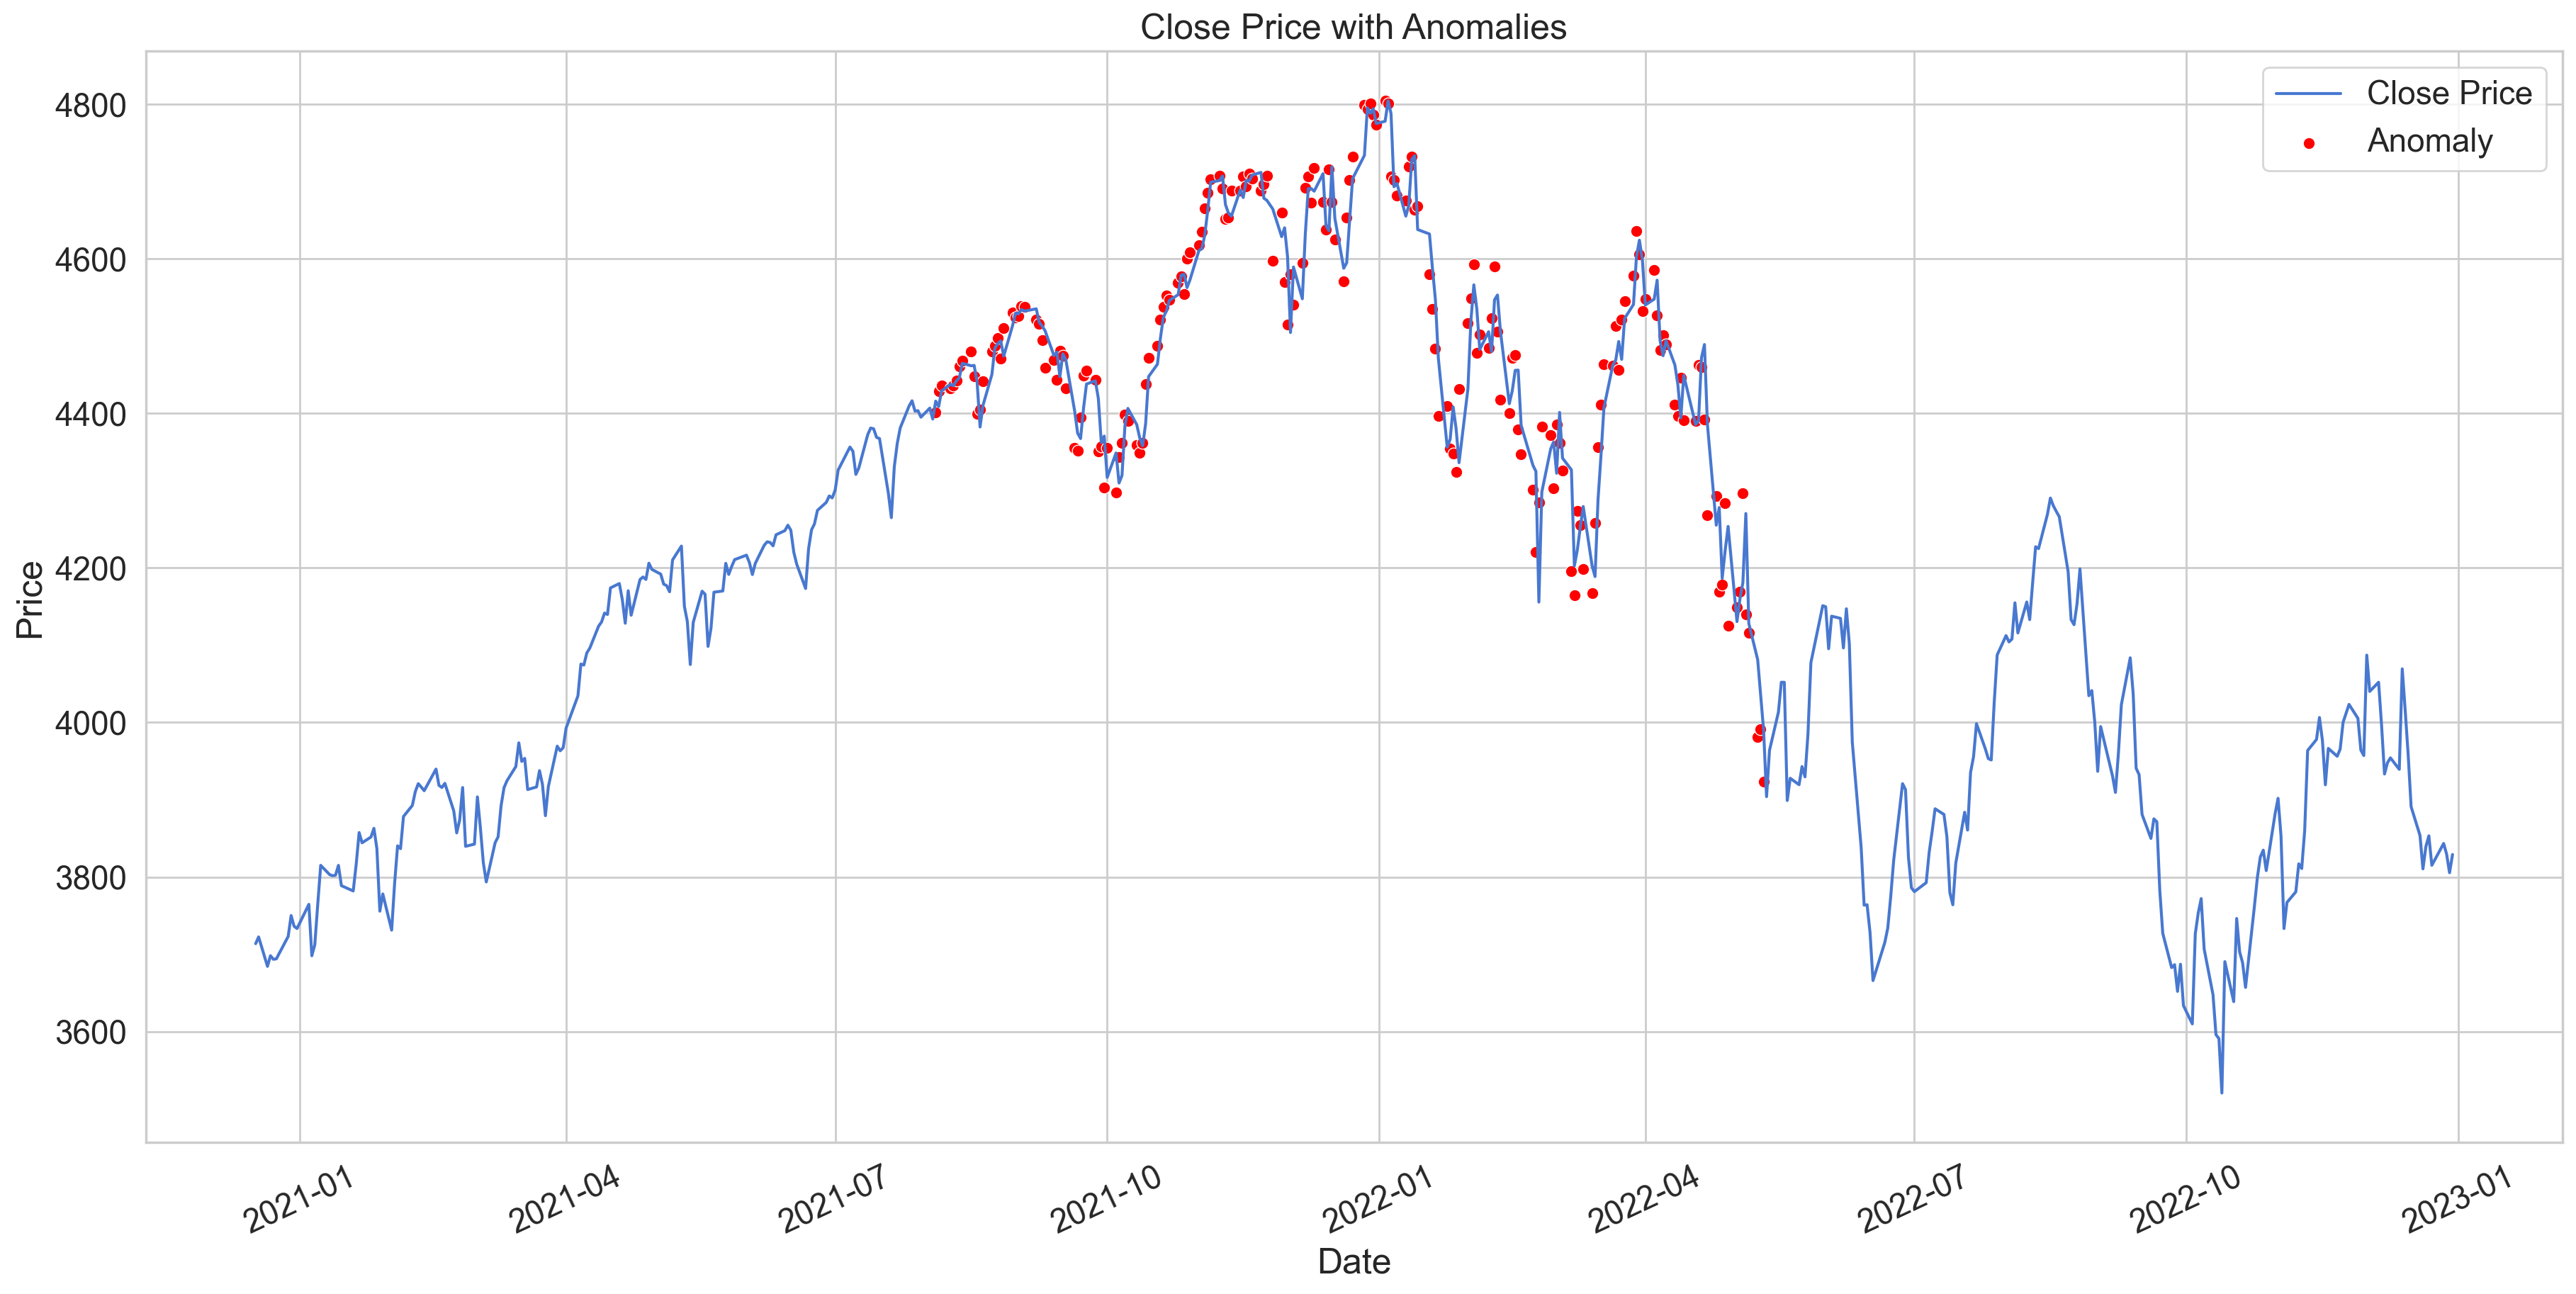

In [64]:
scaled_test = scaler.inverse_transform(test[TIME_STEPS:]) 
scaled_anomalies=scaler.inverse_transform(anomalies)
plt.plot(
    test[TIME_STEPS:].index, 
    scaled_test[:, 3], 
    label='Close Price'
)

sns.scatterplot(
    x=anomalies.index, 
    y=scaled_anomalies[:,3],  
    color='red',
    label='Anomaly'
)

plt.legend()
plt.title("Close Price with Anomalies")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=25)
plt.show()